# Теория

In [1]:
from scipy.ndimage import filters 
from matplotlib import pyplot as plt 
from numpy import *
from PIL import Image #загрузка из Pillow класса Image

In [2]:
def compute_harris_response (im, sigma=3) : 
    """ Вычислить функцию отклика детектора углов Харриса для каждого пикселя полутонового изображения. """
    # производные 
    imx = zeros(im.shape) 
    filters.gaussian_filter(im,(sigma,sigma), (0,1), imx) 
    imy = zeros(im.shape) 
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy) 
    # вычислить элементы матрицы Харриса 
    Wxx = filters.gaussian_filter (imx*imx, sigma) 
    Wxy = filters.gaussian_filter (imx*imy, sigma) 
    Wyy = filters.gaussian_filter (imy*imy, sigma) 
    # определитель и след матрицы 
    Wdet = Wxx*Wyy - Wxy**2 
    Wtr = Wxx + Wyy 
    return Wdet / Wtr

In [3]:
def get_harris_points (harrisim, min_dist=10, threshold=0.1): 
 
    # найти точки-кандидаты, для которых функция отклика больше порога 
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1 
    # получить координаты кандидатов 
    coords = array(harrisim_t.nonzero()).T 
    #... и их значения
    candidate_values = [harrisim[c[0],c[1]] for c in coords] 
    # отсортировать кандидатов 
    index = argsort(candidate_values) 
    # сохранить данные о точках-кандидатах в массиве 
    allowed_locations = zeros(harrisim.shape) 
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1 
    # выбрать наилучшие точки с учетом min_distanse 
    filtered_coords = [] 
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1: 
            filtered_coords.append (coords [i] ) 
            allowed_locations [(coords [i,0]-min_dist): (coords[i,0]+min_dist), (coords[i,1]- min_dist):(coords[i,1]+min_dist)] = 0 
    return filtered_coords

In [4]:
def plot_harris_points (image, filtered_coords): 
    plt.figure() 
    plt.gray() 
    plt.imshow(image) 
    plt.plot ([p[1] for p in filtered_coords], [p[0] for p in filtered_coords],'*') 
    plt.axis('off') 
    plt.show() 

/tmp/ipykernel_42906/3827627765.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filters.gaussian_filter(im,(sigma,sigma), (0,1), imx)
/tmp/ipykernel_42906/3827627765.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)
/tmp/ipykernel_42906/3827627765.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Wxx = filters.gaussian_filter (imx*imx, sigma)
/tmp/ipykernel_42906/3827627765.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be remov

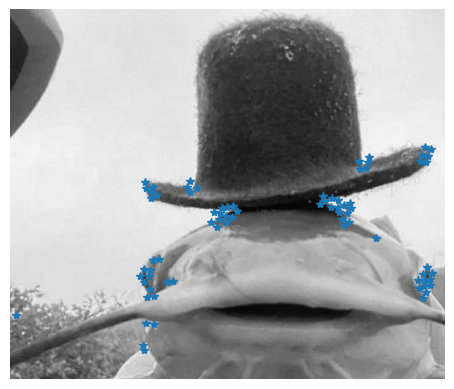

In [5]:
im = array(Image.open('img9.jpg').convert('L')) 
harrisim = compute_harris_response(im) 
filtered_coords = get_harris_points (harrisim, 6) 
plot_harris_points(im, filtered_coords)


In [6]:
def get_descriptors (image, filtered_coords, wid=5): 
    """ Для каждой точки вернуть значения пикселей в окрестности этой точки шириной 2*wid+1.
    (Предполагается, что выбирались точки с min_distanse > wid). """
    desc = [] 
    for coords in filtered_coords: 
        patch = image[coords[0]-wid:coords[0]+wid+1, coords [1]-wid:coords[1]+wid+1] .flatten() 
        desc.append (patch) 
    return desc 

In [7]:
def match (descl,desc2,threshold=0.5): 
    """ Для каждого дескриптора угловой точки в первом изображении найти соответствующую ему точку во втором изображении, применяя нормированную взаимную корреляцию. """
    n = len(descl[0])
    # попарные расстояния 
    d = -ones((len(descl),len(desc2))) 
    for i in range(len(descl)): 
        for j in range(len(desc2)): 
            dl = (descl[i] - mean(descl[i])) / std(descl[i]) 
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j]) 
            nec_value = sum(dl * d2) / (n-1) 
            if nec_value > threshold: 
                d[i,j] = nec_value 
    ndx = argsort (-d)
    matchscores = ndx[:,0] 
    return matchscores



In [8]:
def match_twosided(descl,desc2,threshold=0.5): 
    """ Двусторонний симметричный BapwuaHT match(). """ 
    matches_12 = match (descl, desc2, threshold) 
    matches_21 = match (desc2,descl, threshold) 
    ndx_12 = where(matches_12 >= 0) [0] 
    # исключить несимметричные соответствия 
    for n in ndx_12:
        if matches_21[matches_12[n]] !=n: 
            matches_12[n] = -1. 
    return matches_12


# Упражнения

In [9]:
def appendimages (iml,im2): 
    """ Вернуть новое изображение, на котором два исходных расположены рядом. """
    # выбрать изображение с наименьшим числом строк и дополнить 
    # его пустыми строками 
    rows1 = iml.shape[0]
    rows2 = im2.shape[0] 
    if rows1 < rows2: 
        im1 = concatenate ((im1, zeros ( (rows2-rows1, iml.shape[1]))),axis=0) 
    elif rows1 > rows2:
        im2 = concatenate ((im2, zeros ( (rows1-rows2, im2.shape[1]))),axis=0) 
    # если ни то, ни другое, значит, число строк одинаково
    # и заполнять не нужно 
    return concatenate((iml,im2), axis=1) 


In [10]:
def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True):
    """ Показать рисунок, на котором соответственные точки соединены вход """ 
    im3 = concatenate((im1, im2), axis=1)
    if show_below: 
        im3 = vstack((im3, im3))
    plt.imshow(im3, cmap='gray')
    cols1 = im1.shape[1]
    for i, m in enumerate(matchscores):
        if m > 0:
            plt.plot([locs1[i][1], locs2[m][1] + cols1], [locs1[i][0], locs2[m][0]], 'c')
    plt.axis('off')
    plt.show()

/tmp/ipykernel_42906/3827627765.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filters.gaussian_filter(im,(sigma,sigma), (0,1), imx)
/tmp/ipykernel_42906/3827627765.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)
/tmp/ipykernel_42906/3827627765.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  Wxx = filters.gaussian_filter (imx*imx, sigma)
/tmp/ipykernel_42906/3827627765.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be remov

начинается сопоставление


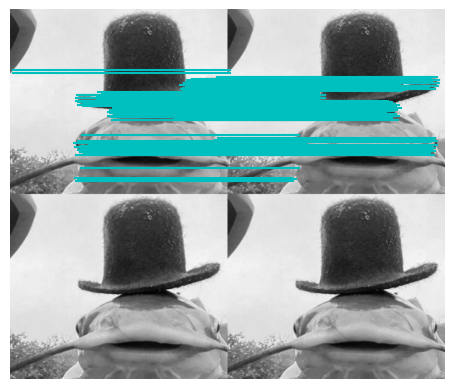

In [11]:
im1 = array(Image.open('img9.jpg').convert('L'))
im2 = array(Image.open('img9.jpg').convert('L'))
wid = 5 
harrisim = compute_harris_response(im1,5) 
filtered_coords1 = get_harris_points (harrisim, wid+1) 
d1 = get_descriptors(im1,filtered_coords1, wid) 
harrisim = compute_harris_response(im2,5) 
filtered_coords2 = get_harris_points (harrisim, wid+1) 
d2 = get_descriptors(im2,filtered_coords2,wid) 
print("начинается сопоставление")
matches = match_twosided(d1,d2) 
plt.figure() 
plt.gray() 
plot_matches (im1,im2, filtered_coords1,filtered_coords2,matches) 
plt.show()


In [12]:
import os

In [13]:
def process_image(imagename, resultname, params='--edge-thresh 10 --peak-thresh 5'):
    if imagename[-3:] != 'pgm':
        im = Image.open(imagename).convert('L') 
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'
    cmmd = str('./vlfeat-0.9.20/bin/win64/sift '+ imagename +' --output=' + resultname+ ' ' + params)
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)

In [14]:
# #прочитаь признаки и вернуть их в виде матрицы
def read_features_from_flle(filename):
    f = loadtxt(filename)
    return f[:,:4],f[:,4:]#положение признаков дескриптора


In [15]:
def write_featuren_tO_file(filename, locs,denc) :
    savetxt(filename,hstack((locs,denc)))


In [16]:
import math 

def plot_features(im,locs,circle=False):
    def draw_circle(c,r):
        t = arange(0,1.01,.01)*2*math.pi
        x = r*math.cos(t) + c[0]
        y=r*math.sin(t) + c[1]
        plt.plot(x,y, 'b',linewidth=2)

    plt.imshow(im)
    if circle:
        for p in locs: 
          draw_circle(p[:2],p[2])
    else:
        plt.plot(locs[:,0],locs[:,1],'ob')
    plt.axis('off')


In [ ]:
# ./vlfeat-0.9.21/bin/win64/sift tmp.pgm --output=empire.sift --edge-thresh 10 --peak-thresh 5

imname = 'img8.jpg'
iml = array(Image.open(imname).convert('L')) 
process_image(imname,'empire.sift')
ll,dl = read_features_from_flle('empire.sift')
plt.figure()
plot_features(iml,ll,circle=True) 
plt.show()
